# ST-590 Final Project
*Performed by: Muhammer Kurt, Nataliya Peshekhodko*

*08/01/2022*

## Introduction

The goals of this project are: 
* Find a data set to explore and fit supervised machine learning models
* Conduct EDA through pandas-on-spark
* Fit three different supervised learning classes of models and choosing a best model

## Dataset

To achieve goals of this project Diabetic Data set from [Kaggle](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) was chosen. This data set is used to predict based on diagnostic measurements whether a patient has diabetes. We build and fit classification models.

Variables in data set:
- *Pregnancies* - number of times pregnant
- *Glucose* - plasma glucose concentration a 2 hours in an oral glucose tolerance test
- *BloodPressure* - diastolic blood pressure (mm Hg)
- *SkinThickness* - triceps skin fold thickness (mm)
- *Insulin* - 2-Hour serum insulin (mu U/ml)
- *BMI* - body mass index (weight in kg/(height in m)^2)
- *DiabetesPedigreeFunction* - diabetes pedigree function
- *Age* - age (years)
- *Outcome* - class variable (0 or 1), 0 if patient is healthy, 1 if patient is diabetic.

## Supervised Learning Idea and Data Split

We are building `supervised machine learning model` which allows to predict whether a patient has diabetes. It called supervised learning because we are training model with data which already has correct label for each patient (0 if patient is healthy, 1 if patient is diabetic).

Binary `logistic regression` algorithm is applied to the selected data set. Logistic Regression is a classification algorithm for categorical variables. It called binary because our target variable is binary, and  can take only two values, 0 or 1.  

Data set is splited up in two parts: train (80% of data) and test (20% of data). Models are built on the training data set and tested on the test data set. To evaluate performance of built machine learning models we need to test it on some unseen data. Performance measure on unseen data  allows us we to understand weather our models are under-fitting, over-fitting or work well on new data(i.e. model generalized well). In other words, we are trying to avoid situation where a machine learning model fits training data perfectly and fails to reliably fit additional data.

We are applying *K-folds* cross validation technique in training process. Cross validation is a re-sampling procedure used to evaluate a model if we have a limited data. To perform cross validation we need to keep aside a sample/portion of the data on which is not used to train the model and use this sample for testing/validating. We are applying *K-folds* cross validation with *K = 5*. Training data set is split up in *K=5* folds. Then fit the model using the *K-1* (4) folds and validate the model using the remaining *K-th* fold. Repeat this process until every K-fold serve as the test set. Then take the average of recorded scores. That is the performance metric for the model. Best model is chosen based on that performance metric. After that, all training data set is used to fit the best model.

We are utilizing `Pyspark pipelines` which allow to create the sequence of data transformations, data assemble, model fits and easily apply the same transformations on the test set.

## Model Quality 

To measure quality of the obtained models, metric `Area Under the ROC Curve (AUC)` is used as `main performance metric`. `Area Under the ROC Curve` is a performance measurement for the classification problems at various threshold settings. ROC curve stands for `Receiver Operating Characteristic` curve. ROC is a probability curve and AUC represents the degree or measure of separability.
The ROC curve is curve with `TPR (True Positive Rate)` against the `FPR (False Positive Rate)` where TPR is on the y-axis and FPR is on the x-axis. Formulas for calculation FPR and TPR are provided below.

$$TPR=\frac{True Positives}{(True Positives + False Negatives)}$$


$$FPR = \frac{False Positives}{(True Negatives + False Positives)}$$

AUC tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. The Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.
An excellent model has Area Under the Curve  near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability.

We are also looking at `Precision-Recall` curve and measure Precison and Recall for each model. `Precision` is a metric that quantifies the number of correct positive predictions made.

$$Precision = \frac{True Positives}{(True Positives + False Positives)}$$

Recall is another name used for TPR. Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

$$Recall=\frac{True Positives}{(True Positives + False Negatives)}$$


The Precision-Recall curve is curve with Recall on the x-axis and Precision on y-axis. The precision-recall curve shows the trade off between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

## Data preparation

Import libraries and set up spark session.

In [68]:
# supress all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import os
import sys
import pyspark.pandas as ps
from pyspark.sql import SparkSession

from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import VectorAssembler
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.getOrCreate()

Read data from `diabetics.csv` file and display first 5 rows.

In [70]:
data = pd.read_csv("data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Before split up data into train and test data sets we need to replace zero values for Blood Pressure and Body Mass Index. These variables can't be equal to zero in real life but in the data set there are some records with zeros for these variables

In [71]:
print ("Number of 0 values for Diastolic Blood Pressure is "+ str(data[data.BloodPressure==0].BloodPressure.count()) +  
       "\nNumber of 0 values for Body Mass Index is " + str (data[data.BMI==0].BMI.count()))

Number of 0 values for Diastolic Blood Pressure is 35
Number of 0 values for Body Mass Index is 11


We replace zero values for these variables with means for these variables (mean calculation is adjusted not to include observations with zeros).

In [72]:
data.BloodPressure.replace(0,data[data.BloodPressure!=0].BloodPressure.mean(),inplace=True)
data.BMI.replace (0, data[data.BMI!=0].BMI.mean(),inplace=True)

EDA is conducted on Spark data frame. Convert pandas data frame into spark data frame and display 5 first rows.

In [73]:
diabetes = spark.createDataFrame(data)
diabetes.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|         72.0|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|         66.0|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|         64.0|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|         66.0|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|         40.0|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



Randomly split up data set into training (80% of data) and testing (20% of data) data sets and display row counts for each part.

In [6]:
train, test = diabetes.randomSplit([0.8,0.2], seed = 1)
print(train.count(), test.count())

607 161


Display first 5 rows of the train data set.

In [7]:
train.show(5)

+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|    BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
|          0|    100|             88.0|           60|    110|46.8|                   0.962| 31|      0|
|          0|    101|             65.0|           28|      0|24.6|                   0.237| 22|      0|
|          0|    105|             64.0|           41|    142|41.5|                   0.173| 22|      0|
|          0|    109|             88.0|           30|      0|32.5|                   0.855| 38|      1|
|          0|    131|72.40518417462484|            0|      0|43.2|                    0.27| 26|      1|
+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



## Exploratory data analysis

In this section we conduct explanatory data analysis (EDA) on training data set. The goal of the EDA is to understand the data and try to gather as many insights from it.

Let's start with describing all numeric feature variables (*splitting up into two tables for easy reading*). We would like to see if there are any anomalies in min, max values for diagnostic measurements. 

In [8]:
train.select('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness' ).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|       Pregnancies|           Glucose|     BloodPressure|     SkinThickness|
+-------+------------------+------------------+------------------+------------------+
|  count|               607|               607|               607|               607|
|   mean|3.7891268533772653|119.36738056013179| 72.65923480269974|20.191103789126853|
| stddev| 3.322840308863052|31.996263038169634|12.153251936684262|15.679958827932095|
|    min|                 0|                 0|              24.0|                 0|
|    max|                15|               199|             122.0|                63|
+-------+------------------+------------------+------------------+------------------+



In [9]:
train.select('Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age' ).describe().show()

+-------+-----------------+-----------------+------------------------+------------------+
|summary|          Insulin|              BMI|DiabetesPedigreeFunction|               Age|
+-------+-----------------+-----------------+------------------------+------------------+
|  count|              607|              607|                     607|               607|
|   mean| 75.0313014827018|32.50078193858964|      0.4653492586490939| 33.27347611202636|
| stddev|110.6757998930512| 6.96829781648047|     0.32853833196886145|11.871187278518361|
|    min|                0|             18.2|                   0.085|                21|
|    max|              846|             67.1|                    2.42|                81|
+-------+-----------------+-----------------+------------------------+------------------+



From the data above we do not see anomalies in min, max or mean values for the feature variables. There are zero min values for variables `Pregnancies`, `Glucose`, `SkinThickness` and `Insulin` which is acceptable.

Let's count the number of diabetic and normal patients in the train data set in order to understand if there any bias in data towards diabetic or healthy patients.

In [10]:
train.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      0|  401|
|      1|  206|
+-------+-----+



In the train data set we have almost twice more observations for healthy patients comparing with diabetics patients. However, we have enough data for both types of outcome to train machine learning model.

Check if there are any null values in the train data set.

In [11]:
import pyspark.sql.functions as f
# checking for null values in each column
data_agg = train.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in train.columns])
data_agg.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



There are no *NULL* values in the data set.

Further, in the EDA section we are doing data analysis in the context of the `Outcome` variable. We want to understand if there are any differences in diagnostic variables distributions, interactions between these variables, differences in measurements for diabetic and healthy patients and which variables should be included in the machine learning model. 
Let's look at `min`, `mean` and `max` values for each numeric feature variable in the context of the outcome variable.

In [12]:
expl_vars = ['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin',
            'DiabetesPedigreeFunction', 'Age', 'BMI']

min_values = train.groupBy('Outcome').agg({var: 'min' for var in expl_vars})
min_values.show()

# Split up avg in two parts for easy reading output
avg = train.groupBy('Outcome').agg({var: 'avg' for var in expl_vars[0:4]})
avg.show()
avg = train.groupBy('Outcome').agg({var: 'avg' for var in expl_vars[4:]})
avg.show()

max_values = train.groupBy('Outcome').agg({var: 'max' for var in expl_vars})
max_values.show()

+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+
|Outcome|min(Pregnancies)|min(Insulin)|min(DiabetesPedigreeFunction)|min(SkinThickness)|min(Age)|min(BloodPressure)|min(BMI)|min(Glucose)|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+
|      0|               0|           0|                        0.085|                 0|      21|              24.0|    18.2|           0|
|      1|               0|           0|                        0.088|                 0|      21|              30.0|    23.3|           0|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+

+-------+------------------+------------------+------------------+-----------------+
|Outcome|avg(BloodPressure)|      avg(Glucose)|avg(SkinThickness)| avg(Pregnanci

From the tables above it could be seen that 
- min values for the variables `BloodPressure` and `BMI` for healthy patients are lower comparing with mean values for diabetic patients
- average values for the variables `Glucose`, `Insulin`, `Age` and `BloodPressure` are higher for diabetics patients comparing with healthy patients

Let's visualize distributions for each numeric variable in the context of the outcome variable.

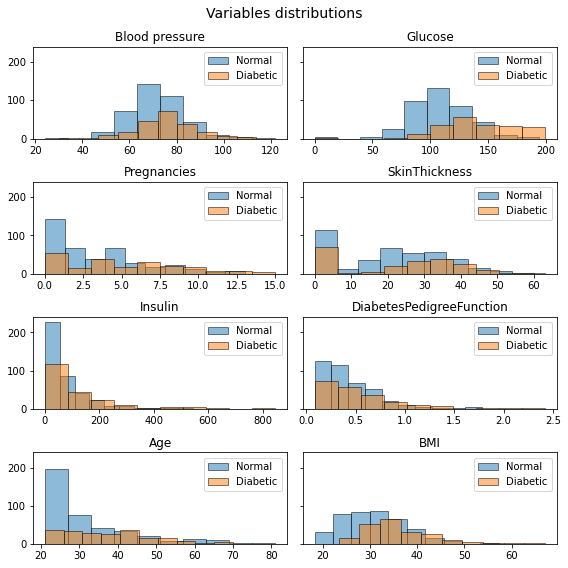

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
ps.options.plotting.backend = 'matplotlib'

eda_train = train.to_pandas_on_spark()

fig, axs = plt.subplots(4, 2, sharey=True, tight_layout=True, figsize = (8, 8))
fig.suptitle("Variables distributions", fontsize=14)
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "0", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label="Normal")
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "1", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label = "Diabetic")
axs[0,0].set_title("Blood pressure")
axs[0,0].legend()


axs[0,1].hist(eda_train.loc[eda_train.Outcome == "0", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label="Normal")
axs[0,1].hist(eda_train.loc[eda_train.Outcome == "1", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label = "Diabetic")
axs[0,1].set_title("Glucose")
axs[0,1].legend()

axs[1,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label="Normal")
axs[1,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label = "Diabetic")
axs[1,0].set_title("Pregnancies")
axs[1,0].legend()

axs[1,1].hist(eda_train.loc[eda_train.Outcome == "0", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label="Normal")
axs[1,1].hist(eda_train.loc[eda_train.Outcome == "1", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label = "Diabetic")
axs[1,1].set_title("SkinThickness")
axs[1,1].legend()

axs[2,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label="Normal")
axs[2,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label = "Diabetic")
axs[2,0].set_title("Insulin")
axs[2,0].legend()

axs[2,1].hist(eda_train.loc[eda_train.Outcome == "0", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label="Normal")
axs[2,1].hist(eda_train.loc[eda_train.Outcome == "1", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label = "Diabetic")
axs[2,1].set_title("DiabetesPedigreeFunction")
axs[2,1].legend()

axs[3,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Age"]].Age,  alpha = 0.5, ec="black", label="Normal")
axs[3,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Age"]].Age,  alpha = 0.5, ec="black", label = "Diabetic")
axs[3,0].set_title("Age")
axs[3,0].legend()

axs[3,1].hist(eda_train.loc[eda_train.Outcome == "0", ["BMI"]].BMI,  alpha = 0.5, ec="black", label="Normal")
axs[3,1].hist(eda_train.loc[eda_train.Outcome == "1", ["BMI"]].BMI,  alpha = 0.5, ec="black", label = "Diabetic")
axs[3,1].set_title("BMI")
axs[3,1].legend()

From the histograms above it could be seen that distributions of `Glucose`, `Insulin`, `Age` and `BMI` might be different for each outcome. 

Let's look at boxplot for each numeric variable in the context of the outcome variable. Boxplots allow us to look at distribution of each numeric variable based on minimum, first quartile (Q1), median, third quartile (Q3), and maximum. It can tell us about outliers and what their values are.

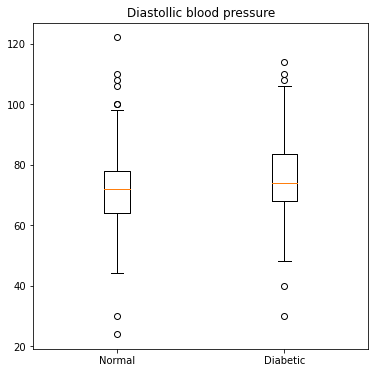

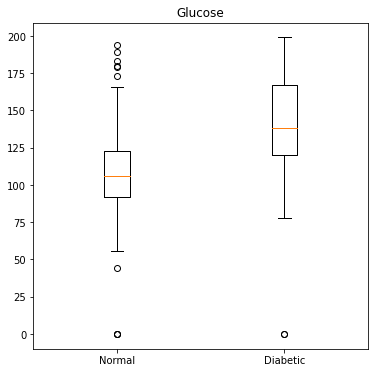

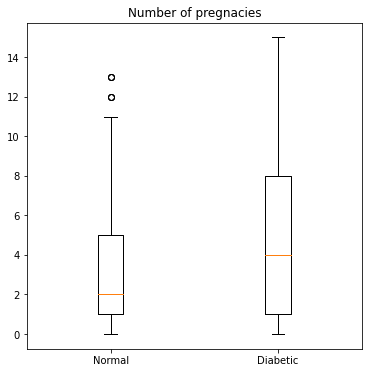

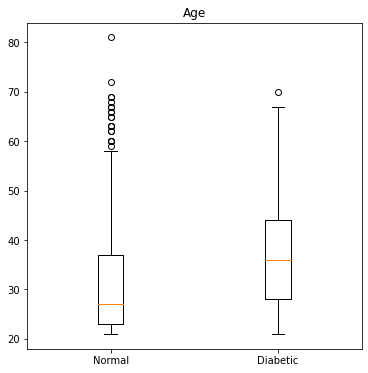

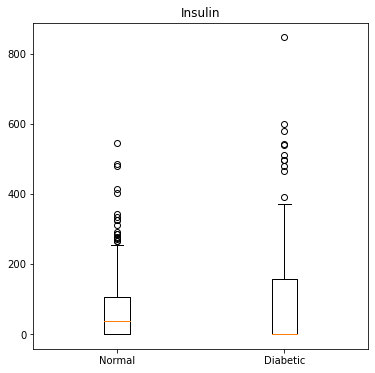

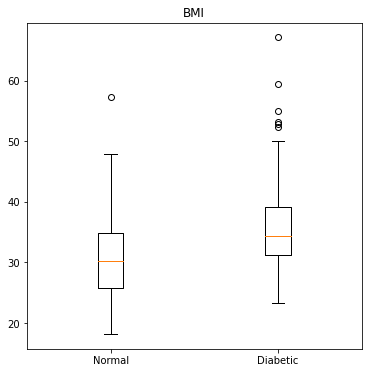

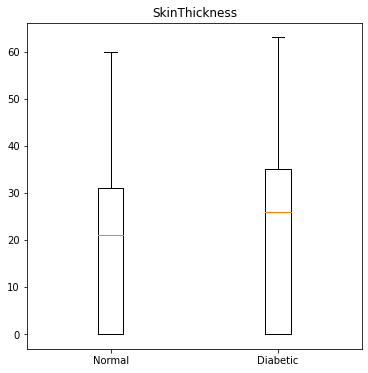

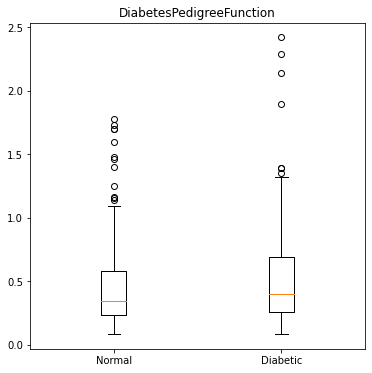

In [14]:
plt.rcParams['figure.figsize'] = [6, 6]
a = eda_train.loc[eda_train['Outcome'] == 0, 'BloodPressure']
b = eda_train.loc[eda_train['Outcome'] == 1, 'BloodPressure']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Diastollic blood pressure')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'Glucose']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Glucose']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Glucose')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'Pregnancies']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Pregnancies']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Number of pregnacies')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'Age']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Age']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Age')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'Insulin']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Insulin']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Insulin')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'BMI']
b = eda_train.loc[eda_train['Outcome'] == 1, 'BMI']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('BMI')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'SkinThickness']
b = eda_train.loc[eda_train['Outcome'] == 1, 'SkinThickness']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('SkinThickness')
plt.show()

a = eda_train.loc[eda_train['Outcome'] == 0, 'DiabetesPedigreeFunction']
b = eda_train.loc[eda_train['Outcome'] == 1, 'DiabetesPedigreeFunction']
data = [a,b]
for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])
plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('DiabetesPedigreeFunction')
plt.show()

From the graphs above it could be concluded that medians for `Age`, `Pregnacies`, `Glucose` and `BMI` are higher for diabetics patients comparing with healthy patients. Median for `BloodPressure` is slightly higher for diabetic patients comparing with healthy patients.  Median for `Insulin` is lower (and completely equal to zero) for diabetic patients comparing with healthy patients. 50% of data (box itself) is more wider for diabetic patients for variables `Pregnancies`, `Age` and `SkinThickness`.

Now, let's see if there is correlation between any numeric variables in order to avoid multicollinearity in the machine learning models.

In [15]:
eda_train[['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin','DiabetesPedigreeFunction', 'Age', 'BMI']].corr()

22/07/26 15:57:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/07/26 15:57:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


,BloodPressure,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,BMI
BloodPressure,1.000000,0.189019,0.230920,0.007712,-0.054817,-0.011798,0.335703,0.242875
Pregnancies,0.189019,1.000000,0.125612,-0.096489,-0.061967,-0.066191,0.540907,-0.009001
Glucose,0.230920,0.125612,1.000000,0.045829,0.295180,0.107185,0.261922,0.224549
SkinThickness,0.007712,-0.096489,0.045829,1.000000,0.449423,0.176543,-0.128871,0.375401
Insulin,-0.054817,-0.061967,0.295180,0.449423,1.000000,0.137497,-0.017874,0.157282
DiabetesPedigreeFunction,-0.011798,-0.066191,0.107185,0.176543,0.137497,1.000000,0.022669,0.154629
Age,0.335703,0.540907,0.261922,-0.128871,-0.017874,0.022669,1.000000,0.006848
BMI,0.242875,-0.009001,0.224549,0.375401,0.157282,0.154629,0.006848,1.000000


There are no significant correlation between numeric variables in the data set.

Let's look at relationship between some numeric variables in context of the outcome variable. The goal of these plots is to explore if there are different interactions between these variables for diabetic and healthy patients.

<AxesSubplot:title={'center':'Age vs insulin'}, xlabel='Age', ylabel='Insulin'>

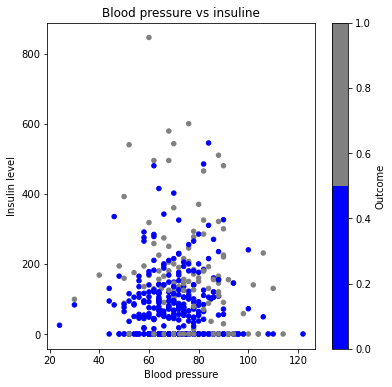

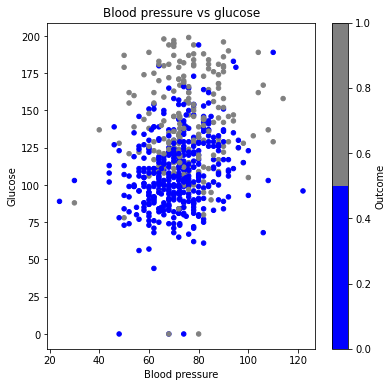

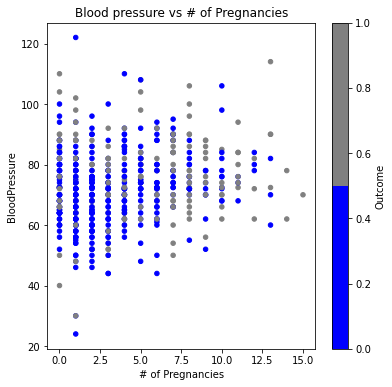

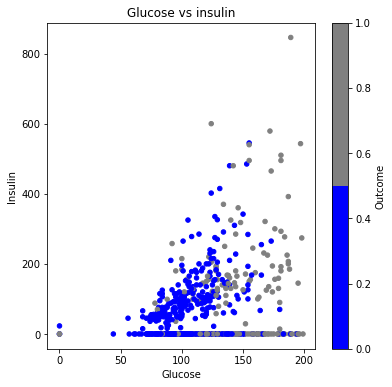

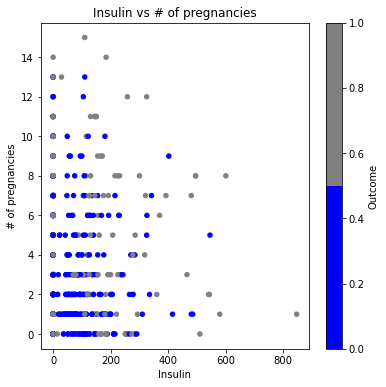

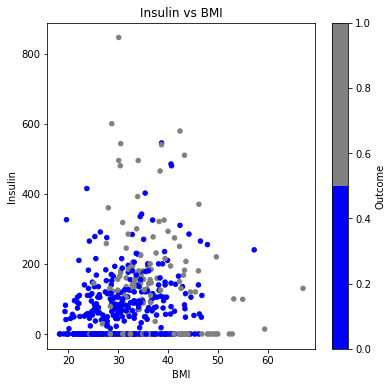

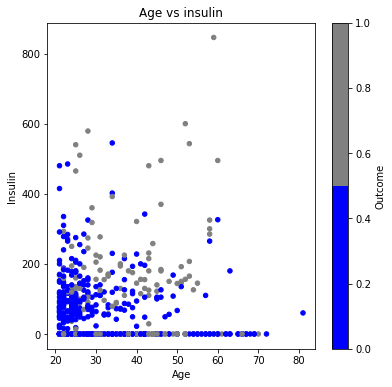

In [16]:
mycmap = colors.ListedColormap(['blue', 'grey'])

eda_train.plot.scatter(x='BloodPressure', y='Insulin', c = 'Outcome', colormap = mycmap, 
                       ylabel = "Insulin level", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs insuline",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='BloodPressure', y='Glucose', c = 'Outcome', colormap = mycmap,
                       ylabel = "Glucose", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs glucose",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='Pregnancies', y='BloodPressure', c = 'Outcome', colormap = mycmap,
                       ylabel = "BloodPressure", 
                       xlabel = "# of Pregnancies",
                       title = "Blood pressure vs # of Pregnancies",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='Glucose', y='Insulin', c = 'Outcome', colormap = mycmap, 
                       ylabel = "Insulin", 
                       xlabel = "Glucose",
                       title = "Glucose vs insulin",
                       sharex = False,
                       figsize = (6, 6))
eda_train.plot.scatter(x='Insulin', y='Pregnancies', c = 'Outcome', colormap = mycmap, 
                       ylabel = "# of pregnancies", 
                       xlabel = "Insulin",
                       title = "Insulin vs # of pregnancies",
                       sharex = False,
                       figsize = (6, 6))
eda_train.plot.scatter(x='BMI', y='Insulin', c = 'Outcome', colormap = mycmap,
                       ylabel = "Insulin", 
                       xlabel = "BMI",
                       title = "Insulin vs BMI",
                       sharex = False,
                       figsize = (6, 6))
eda_train.plot.scatter(x='Age', y='Insulin', c = 'Outcome', colormap = mycmap,
                       ylabel = "Insulin", 
                       xlabel = "Age",
                       title = "Age vs insulin",
                       sharex = False,
                       figsize = (6, 6))

From the graphs above it could be concluded that there is no significant difference in interaction between `Insulin` and `BloodPressure`, `BloodPressure` and `Pregnancies`, `Insulin` and `Pregancies`, `Insulin` and `BMI`, `Age` and `Insulin` for each type of outcome. However, there are might be difference in interaction for `BloodPressure` and `Glucose`, `Glucose` and `Insulin` for each type of outcome. It make sense to consider such interactions in the model.

## Modeling 

Three different logistic regression models are fitted. As an input parameters, each model uses combination of numeric diagnostic measurements. In addition, Model One and Model Two have logarithm transformation applied to some variables, Model One also has second degree polynomial transformation applied to selected features. Model Three has two interaction terms. 

Before, making prediction 0 (healthy patient) or 1 (diabetic patient), each model calculate probability of outcome = 0 (being healthy patient). For all model default **probability cut off = 0.5** is used. If probability of being healthy < 0.5, patient predicted as diabetic, otherwise model predicts patient as healthy.

### Model 1

First model is fitted with `Glucose`, `Insulin`, `Pregnancies`, `BMI` and  `log(Age)`. Polynomial second degree transformation is applied to  `Glucose`, `Insulin` features. Spark pipeline is used to set up all transformations for train and test data sets.

Import pyspark machine learning libraries.

In [17]:
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Create object of logistic regression class.

In [18]:
lr = LogisticRegression()

Set up variable selection and transformation.

In [19]:
sqlTrans = SQLTransformer(
    statement = "SELECT log(Age) as Age, Glucose, \
    Insulin, Pregnancies, BMI, \
    outcome as label FROM __THIS__")

With `VectorAssemler` assemble columns `Glucose`, `Insulin` into single column which is used as an input column for polynomial transformation.

In [20]:
assembler1 = VectorAssembler(inputCols = ["Glucose", "Insulin"], 
                            outputCol = "for_poly_transform")

Apply second degree polynomial transformation to selected on the previous step features. Output results into dedicated column.

In [21]:
px = PolynomialExpansion(degree=2, inputCol="for_poly_transform", outputCol="poly_transformed")

Set up another assembler stage to assemble column with polynomial transformations and columns `log(Age)`, `Pregnancies`, `BMI` into `features` column which is used as an input for logistic regression model.

In [22]:
assembler2 = VectorAssembler(inputCols = ["Age", "Pregnancies", "BMI", "poly_transformed"], outputCol="features")

Set up pipeline with 5 stages.

In [23]:
pipeline = Pipeline(stages = [sqlTrans, assembler1, px, assembler2, lr])

As it was discussed in the **Model Quality** section, we use cross-validation to find best model with default performance metric `areaUnderROC`. Create parameter grid for cross validation.

In [24]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 0.5, 1.0, 2.0]) \
             .addGrid(lr.fitIntercept, [False, True]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
             .build())

Create 5 folds cross validator.

In [25]:
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

Retrieve default metric used by `BinaryClassificationEvaluator`.

In [26]:
BinaryClassificationEvaluator().getMetricName()

'areaUnderROC'

`areaUnderROC` as described in **Model Quality** section at the beginning is used as model performance metric.

Fitting the best model for the whole train data set.

In [27]:
cvModel = crossval.fit(train)

Let's look at coefficients for the best model

In [28]:
print(cvModel.bestModel.stages[4]._java_obj.intercept(), cvModel.bestModel.stages[4]._java_obj.coefficients())

-8.003014036898332 [0.5806479110416003,0.11488510503941414,0.10990267020374472,-0.015250903472501305,1.9791877262711802E-4,-0.004566662770366408,1.706196135162187E-5,4.583576126981764E-6]


Next, plot the ROC curve for derived model. As it was discussed at the beginning of the document - area under this curve is the performance metric we measure for our model. An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability.

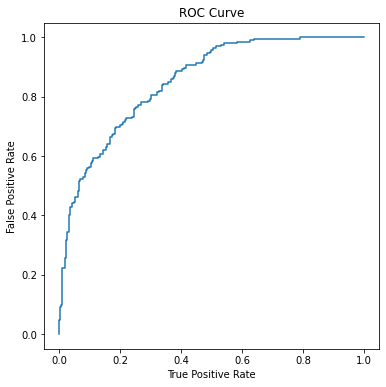

In [29]:
model_t= cvModel.bestModel.stages[4] 
trainingSummary = model_t.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The target area under the ROC curve is as close as possible to one. We can roughly estimate area under the curve and conclude that we are missing somewhere around 20% of the area in order for area to be equal to 1.

Let's looks at Precision vs Recall for derived model. The precision-recall curve shows the trade off between precision and recall for different threshold. 

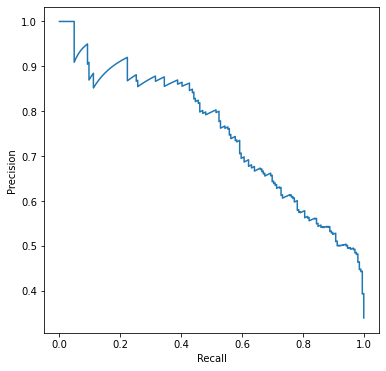

In [30]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Excellent model should have area under the Precision-Recall curve equal to 1. From the graph above it could be seen that the model has area less than 1. 

Using derived model, predict outcome on test data set and show 5 first records.

In [31]:
cvModel.transform(test).show(5)

+------------------+-------+-------+-----------+----+-----+------------------+--------------------+--------------------+--------------------+--------------------+----------+
|               Age|Glucose|Insulin|Pregnancies| BMI|label|for_poly_transform|    poly_transformed|            features|       rawPrediction|         probability|prediction|
+------------------+-------+-------+-----------+----+-----+------------------+--------------------+--------------------+--------------------+--------------------+----------+
|3.4339872044851463|    118|    230|          0|45.8|    1|     [118.0,230.0]|[118.0,13924.0,23...|[3.43398720448514...|[0.36411949341802...|[0.59003728019563...|       0.0|
|3.4339872044851463|     85|      0|          1|26.6|    0|        [85.0,0.0]|[85.0,7225.0,0.0,...|[3.43398720448514...|[2.83714407054310...|[0.94465032632770...|       0.0|
| 3.044522437723423|     89|     94|          1|28.1|    0|       [89.0,94.0]|[89.0,7921.0,94.0...|[3.04452243772342...|[3.0677095

Evaluate derived predictions. Retrieve `areaUnderROC` for obtained predictions for the test data set.

In [32]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print("Performance metric for Model 1 is areaUnderROC = " + str(metric))

Performance metric for Model 1 is areaUnderROC = 0.7670250896057349


Now, we derive and visualize confusion matrix. First, display non-normalized confusion matrix.

In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix_non_norm = confusion_matrix(y_true, y_pred)
cnf_matrix_norm=confusion_matrix (y_true, y_pred, normalize='true')

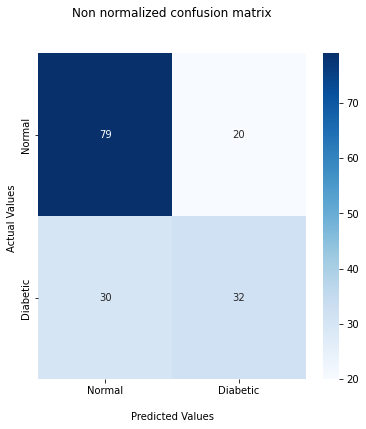

In [34]:
import seaborn as sns

ax = sns.heatmap(cnf_matrix_non_norm, annot=True, cmap='Blues')
ax.set_title('Non normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

From the matrix above we can see that model correctly classify as normal 79 patients and 32 patients as diabetic. However, model misclassify 20 normal patients as diabetic and 30 diabetic patients as normal.

Let's normalize these metrics to better understand model performance and display normalized confusion matrix.

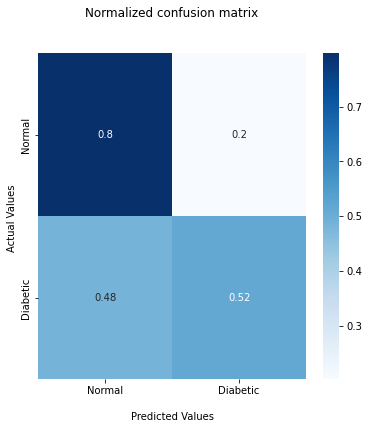

In [35]:
ax = sns.heatmap(cnf_matrix_norm, annot=True, cmap='Blues')
ax.set_title('Normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

For the test data set, obtained model correctly predicted 80% of healthy patients and correctly predicted 52% of diabetic patients. Model misclassify 20% of normal as diabetic and 48% of diabetic as normal.

Finally, lets calculate Precision and Recall for the Model 1.

In [36]:
tp = cnf_matrix_non_norm[0][0] 
fp = cnf_matrix_non_norm[1][0] 
fn = cnf_matrix_non_norm[0][1] 
tn = cnf_matrix_non_norm[1][1] 

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print ("Model 1 has precision = " + str(precision) + " recall = " + str (recall))

Model 1 has precision = 0.7247706422018348 recall = 0.797979797979798


Recall is a measure of how well model can detect positive cases. In our case, measure how well model can detect healthy patients. Model 1 could correctly detect healthy patients 80% of times. 

### Model 2

Second model is fitted with `all numerical variables` from the data set and `log` transformation is applied to `BloodPressure` and `Age`variables. 

Set up variable selection and transformation.

In [37]:
sqlTrans = SQLTransformer(
    statement = "SELECT log(Age) as Age, log(BloodPressure) as BloodPressure, \
    Pregnancies, Glucose, SkinThickness, \
    Insulin, DiabetesPedigreeFunction, BMI, \
    outcome as label FROM __THIS__")

With `VectorAssemler` assemble all selected columns into single column.

In [38]:
assembler = VectorAssembler(inputCols = ["Age", "BloodPressure", 
                                         "Pregnancies", "Glucose", 
                                         "SkinThickness", "Insulin", 
                                         "DiabetesPedigreeFunction", 
                                         "BMI"], 
                            outputCol = "features", handleInvalid = 'keep')

Set up pipeline with 3 stages.

In [39]:
pipeline = Pipeline(stages = [sqlTrans, assembler, lr])

As it was done before, we use cross-validation to find best model with default performance metric `areaUnderROC`. Create parameter grid for cross validation.

In [40]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 0.5, 1.0, 2.0]) \
             .addGrid(lr.fitIntercept, [False, True]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
             .build())

Create 5 folds cross validator.

In [41]:
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

Fitting the best model to the whole train data set.

In [42]:
cvModel = crossval.fit(train)

Checking regression coefficients for the best model

In [43]:
print(cvModel.bestModel.stages[2]._java_obj.intercept(), cvModel.bestModel.stages[2]._java_obj.coefficients())

-8.600768721417879 [0.7670123185709335,-0.8838059211993762,0.12092443307022574,0.03588372524574701,-0.007987407132017905,-1.904942159906886E-4,0.7827355619193522,0.11797231057322712]


Next, plot the ROC curve for the derived model

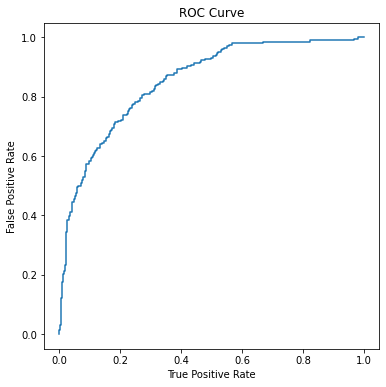

In [44]:
model2= cvModel.bestModel.stages[2]
trainingSummary = model2.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The target area under the ROC curve is as close as possible to one. We can see that this model has opportunity for improvement.

Let's look at Precision-Recall curve.

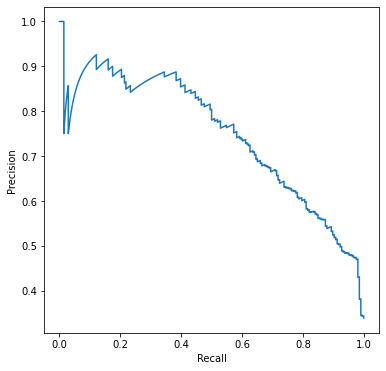

In [45]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Precision recall curve is less smooth for this model comparing with first model. Our goal is to maximize area under this curve.

Use obtained model against test data set and predict outcomes. First 5 rows with predictions are shown.

In [46]:
cvModel.transform(test).show(5)

+------------------+-----------------+-----------+-------+-------------+-------+------------------------+----+-----+--------------------+--------------------+--------------------+----------+
|               Age|    BloodPressure|Pregnancies|Glucose|SkinThickness|Insulin|DiabetesPedigreeFunction| BMI|label|            features|       rawPrediction|         probability|prediction|
+------------------+-----------------+-----------+-------+-------------+-------+------------------------+----+-----+--------------------+--------------------+--------------------+----------+
|3.4339872044851463|4.430816798843313|          0|    118|           47|    230|                   0.551|45.8|    1|[3.43398720448514...|[0.23336346334338...|[0.55807753676093...|       0.0|
|3.4339872044851463|4.189654742026425|          1|     85|           29|      0|                   0.351|26.6|    0|[3.43398720448514...|[3.31748998693507...|[0.96502397054851...|       0.0|
| 3.044522437723423|4.189654742026425|       

Evaluate derived predictions. Retrieve areaUnderROC for obtained predictions for the test data set.

In [47]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print("Performance metric for Model 2 is areaUnderROC = " + str(metric))

Performance metric for Model 2 is areaUnderROC = 0.7896709025741284


We derive and visualize confusion matrix. First, display non-normalized confusion matrix.

In [48]:
y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix_non_norm = confusion_matrix(y_true, y_pred)
cnf_matrix_norm=confusion_matrix (y_true, y_pred, normalize='true')

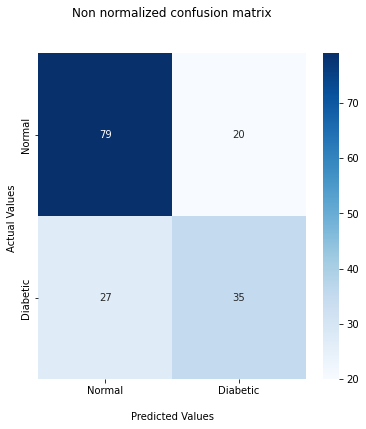

In [49]:
ax = sns.heatmap(cnf_matrix_non_norm, annot=True, cmap='Blues')
ax.set_title('Non normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

From the matrix above we can see that model correctly classify as normal 79 patients and 35 patients as diabetic. However, model misclassify 20 normal patients as diabetic and 27 diabetic patients as normal from the test data set.

Let's normalize these metrics to better understand model performance and display normalized confusion matrix.

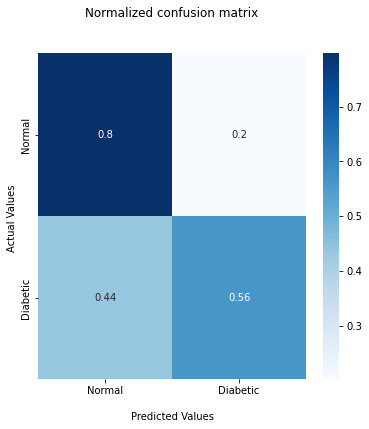

In [50]:
ax = sns.heatmap(cnf_matrix_norm, annot=True, cmap='Blues')
ax.set_title('Normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

For the test data set second model correctly predicted 80% of healthy patients and 56% of diabetic patients . Model misclassify 20% of normal as diabetic and 44% of diabetic as normal.

Lets calculate Precision and Recall for the Model 2.

In [51]:
tp = cnf_matrix_non_norm[0][0] 
fp = cnf_matrix_non_norm[1][0] 
fn = cnf_matrix_non_norm[0][1] 
tn = cnf_matrix_non_norm[1][1] 

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print ("Model 2 has precision = " + str(precision) + " recall = " + str (recall))

Model 2 has precision = 0.7452830188679245 recall = 0.797979797979798


Model 2 could correctly detect healthy patients 80% of times.

### Model 3

Based on the EDA, it make sense to include interactions between some variables in the model. Third model is fitted using `all numeric variables` and interactions between `BloodPressure` and `Glucose`, `Glucose` and `Insulin`. Spark pipeline is used to set up all transformations for train and test data sets.

Set up variable selection.

In [52]:
from pyspark.ml.feature import Interaction

sqlTrans = SQLTransformer(
    statement = "SELECT Age, BloodPressure, \
    Pregnancies, Glucose, SkinThickness, \
    Insulin, DiabetesPedigreeFunction, BMI, \
    outcome as label FROM __THIS__"
)

Set up two interaction stages: between `BloodPressure`, `Glucose` and between `Insulin`, `Glucose`.

In [53]:
interaction1 = Interaction(inputCols=["BloodPressure", "Glucose"], outputCol="interactedCol1")
interaction2 = Interaction(inputCols=["Insulin", "Glucose"], outputCol="interactedCol2")

With `VectorAssemler` assemble all selected columns and columns with interaction into single column with name `features`.

In [54]:
assembler = VectorAssembler(inputCols = ["Age", "BloodPressure", 
                                         "Pregnancies", "Glucose", 
                                         "SkinThickness", "Insulin",  
                                         "DiabetesPedigreeFunction", "BMI", 
                                         "interactedCol1", "interactedCol2"], 
                            outputCol = "features", handleInvalid = 'keep')

Set up spark pipeline with 5 stages.

In [55]:
pipeline = Pipeline(stages = [sqlTrans, interaction1, interaction2, assembler, lr])

Create parameters grid for cross validation.

In [56]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 0.5, 1.0, 2.0]) \
             .addGrid(lr.fitIntercept, [False, True]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
             .build())

Create 5 folds cross validator.

In [57]:
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

Fitting the obtained best model for the whole train data set.

In [58]:
cvModel = crossval.fit(train)

Checking coefficients for the best model

In [59]:
print(cvModel.bestModel.stages[4]._java_obj.intercept(), cvModel.bestModel.stages[4]._java_obj.coefficients())

-12.46226885635518 [0.009924395776594574,0.035834615381354275,0.13961090316559807,0.06115763958610996,-0.006371036964308929,-0.008395112190962352,0.8321290669536725,0.11834780346897546,-3.7427408745340066E-4,5.510801605025273E-5]


Let's build ROC curve for the model.

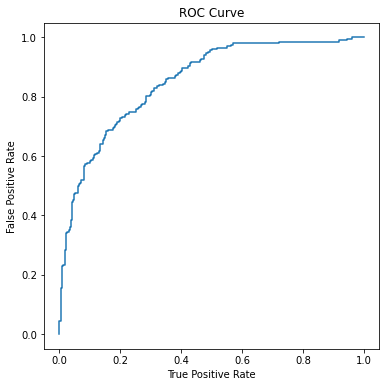

In [60]:
model3= cvModel.bestModel.stages[4]
trainingSummary = model3.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Rough visual estimation of the area under the ROC curve tells that model missing approximately 20% from area under the curve to be equal to 1.

Now, let's plot precision vs recall plot.

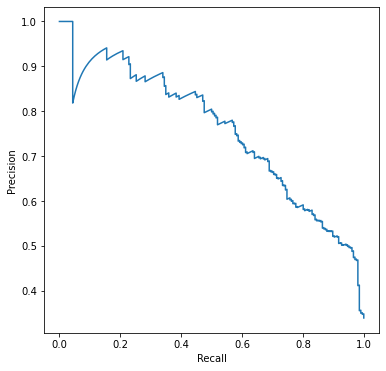

In [61]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Our goal is to maximize area under this curve. From the graph above we can we that there are some fluctuations around recall=0 and area under the curve about 30% less than 1.

Run obtained model against the test data set and predict outcomes. The first 5 rows are shown.

In [62]:
cvModel.transform(test).show(5)

+---+-------------+-----------+-------+-------------+-------+------------------------+----+-----+--------------+--------------+--------------------+--------------------+--------------------+----------+
|Age|BloodPressure|Pregnancies|Glucose|SkinThickness|Insulin|DiabetesPedigreeFunction| BMI|label|interactedCol1|interactedCol2|            features|       rawPrediction|         probability|prediction|
+---+-------------+-----------+-------+-------------+-------+------------------------+----+-----+--------------+--------------+--------------------+--------------------+--------------------+----------+
| 31|         84.0|          0|    118|           47|    230|                   0.551|45.8|    1|      [9912.0]|     [27140.0]|[31.0,84.0,0.0,11...|[0.49355864979357...|[0.62094440024700...|       0.0|
| 31|         66.0|          1|     85|           29|      0|                   0.351|26.6|    0|      [5610.0]|         [0.0]|[31.0,66.0,1.0,85...|[3.29582653192947...|[0.96428535839112...|  

Obtain performance metric which is `areaUnderROC`

In [63]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print("Performance metric for Model 3 is areaUnderROC = " + str(metric))

Performance metric for Model 3 is areaUnderROC = 0.7838057999348322


Derive and visualize confusion matrix. First, display non-normalized confusion matrix.

In [64]:
y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix_non_norm = confusion_matrix(y_true, y_pred)
cnf_matrix_norm=confusion_matrix (y_true, y_pred, normalize='true')

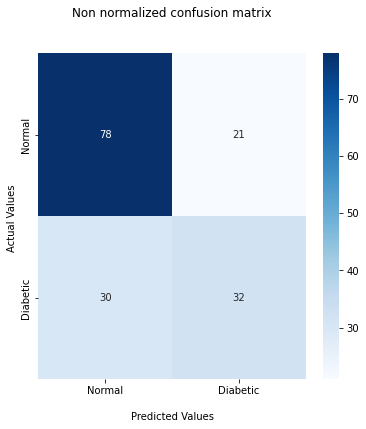

In [65]:
ax = sns.heatmap(cnf_matrix_non_norm, annot=True, cmap='Blues')
ax.set_title('Non normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

From the matrix above we can see that model correctly classified as normal 78 patients and 32 patients as diabetic. However, model misclassify 21 normal patients as diabetic and 30 diabetic patients as normal from the test data set.

Let's normalize these metrics to better understand model performance and display normalized confusion matrix.

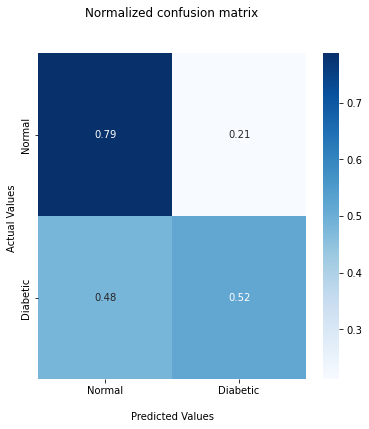

In [66]:
ax = sns.heatmap(cnf_matrix_norm, annot=True, cmap='Blues')
ax.set_title('Normalized confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Normal','Diabetic'])
ax.yaxis.set_ticklabels(['Normal','Diabetic'])
plt.show()

For test data set model correctly predicted 79% of healthy patients and 52% of diabetic patients. Model misclassified 21% of normal as diabetic and 48% diabetic as normal.

In [67]:
tp = cnf_matrix_non_norm[0][0] 
fp = cnf_matrix_non_norm[1][0] 
fn = cnf_matrix_non_norm[0][1] 
tn = cnf_matrix_non_norm[1][1]

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print ("Model 3 has precision = " + str(precision) + " recall = " + str (recall))

Model 3 has precision = 0.7222222222222222 recall = 0.7878787878787878


Model 3 could correctly detect healthy patients 79% of times.

## Summary

Three different machining learning models were built and trained on training data set. Each model was evaluated against test data set. Performance metrics were measured. 
* Model 1  *(log(Age),Glucose, Insulin, Pregnancies, BMI plus second degree polynomial transformation applied to Glucose, Insulin)*. Obtained metrics: **areaUnderROC = 0.7670**, **Precision = 0.7248**, **Recall = 0.7980**
* Model 2 *(All numerical variables with log transformation applied to BloodPressure and Age)*. Obtained metrics: **areaUnderROC = 0.7897**, **Precision = 0.7453**, **Recall = 0.7980**
* Model 3 *(All numeric variables and interactions between BloodPressure and Glucose, Glucose and Insulin)*. Obtained metrics: **areaUnderROC = 0.7838**, **Precision = 0.7222**, **Recall = 0.7879**.

All three models performed very close to each other. However, model 2 has slightly higher areaUnderROC metric comparing to other models. This model should be chosen as model to predict based on diagnostic measurements whether a patient has diabetes.